# Fully Connected Neural Network

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f(x, t):
    return (1 - 16  * np.pi**2) * np.sin(x) * np.cos(4 * np.pi * t)

def u(x, t):
    return np.sin(x) * np.cos(4 * np.pi * t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = np.random.rand(n) * L
    t_vals = np.random.rand(n) * t_end
    return (x_vals, t_vals, f(x_vals, t_vals), u(x_vals, t_vals))

In [4]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
bias_train = torch.ones_like(x_norm)  # Bias column of ones
bias_val = torch.ones_like(x_val_norm)
inputs_train = torch.stack([x_norm, t_norm, bias_train], dim=1)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm, bias_val], dim=1)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1)  # Shape: [N_val, 2]

batch_size = 300
training_dataset = torch.utils.data.TensorDataset(inputs_train, outputs_train)
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

train_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [7]:
device = torch.device("cpu")
print("Device: ", device)

Device:  cpu


In [8]:
class FNN(nn.Module):
    # We create FNN as a subclass of nn.Module
    # In this way we import some important methods from the parent class
    def __init__(self, input_size, output_size, hidden_features=64, activation_function=nn.ReLU()):
        super().__init__()
        
        self.activation_function = activation_function
        # In the init method we specify the layers of the neural network
        # ---------------------- student exercise --------------------------------- #
        self.linear_layer_1 = nn.Linear(
            in_features=input_size, out_features=hidden_features, bias=True
        )

        self.linear_layer_2 = nn.Linear(
            in_features=hidden_features, out_features=hidden_features, bias=True
        )

        self.linear_layer_3 = nn.Linear(
            in_features=hidden_features, out_features=hidden_features, bias=True
        )

        self.linear_layer_4 = nn.Linear(
            in_features=hidden_features, out_features=output_size, bias=True
        )
    
        # ---------------------- student exercise --------------------------------- #

    def forward(self, x):
        # The FNN takes a flatten input of dimensions [N, F],
        # where N are the samples and F are the input features (input_size)
        # x is already shaped as [batch_size, 2] from the DataLoader

        # ---------------------- student exercise --------------------------------- #
        x = self.linear_layer_1(x)
        x = self.activation_function(x)
        x = self.linear_layer_2(x)
        x = self.activation_function(x)
        x = self.linear_layer_3(x)
        x = self.activation_function(x)
        x = self.linear_layer_4(x)
        # ---------------------- student exercise --------------------------------- #

        return x

In [9]:
input_size = 3  # x, t, bias
output_size = 2  # f, u;

print(f"The size of input will be = {input_size}")
print(f"The size of output will be = {output_size}")

model = FNN(input_size, output_size, hidden_features=128)
print(model)

The size of input will be = 3
The size of output will be = 2
FNN(
  (activation_function): ReLU()
  (linear_layer_1): Linear(in_features=3, out_features=128, bias=True)
  (linear_layer_2): Linear(in_features=128, out_features=128, bias=True)
  (linear_layer_3): Linear(in_features=128, out_features=128, bias=True)
  (linear_layer_4): Linear(in_features=128, out_features=2, bias=True)
)


In [10]:
model = model.to(device)

In [11]:
batch_size = 128
loss_function = nn.L1Loss()

In [12]:
def train_epoch(model, loader, optimizer, loss_function):
    model.train()  # specifies that the model is in training mode
    losses = []

    for batch in loader:
        inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]

        # 1. Model prediction
        pred = model(inputs)

        # 2. Loss function
        loss = loss_function(pred, target)

        # 3. Append the loss to a list of losses for later analysis. Hint: Use `detach()` and `item()` to extract the loss value from the loss tensor.
        losses.append(loss.detach().item())

        # 4. Backpropagate. Hint: Use the method .backward() to compute the gradients.
        loss.backward()

        # 5. Optimize the weights with the optimizer Hint: Use the method .step() to update the weights.
        optimizer.step()

        # 6. Reset the computed gradients. Hint: Use the method .zero_grad() to reset the gradients.
        optimizer.zero_grad(set_to_none=True)

    return np.array(losses).mean()

In [13]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [14]:
import optuna

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam", "SGD"])
    optimizer_cls = {
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "SGD": torch.optim.SGD,
    }[optimizer_name]

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    activation_name = trial.suggest_categorical("activation", ["ReLU", "Tanh", "SiLU", "ELU"])
    activation_obj = {
        "ReLU": nn.ReLU(),
        "Tanh": nn.Tanh(),
        "SiLU": nn.SiLU(),
        "ELU": nn.ELU(),
    }[activation_name]

    loss_name = trial.suggest_categorical("loss", ["L1", "MSE"])
    loss_function = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}[loss_name]

    model = FNN(input_size, output_size, hidden_features=hidden_size, activation_function=activation_obj)
    model = model.to(device)

    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)

    # epochs to use during tuning; override by setting NUM_EPOCHS_TUNE earlier
    num_epochs = int(globals().get("NUM_EPOCHS_TUNE", 50))

    best_val = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_function)
        validation_loss = evaluation(model, validation_loader, loss_function)
        
        if validation_loss < best_val:
            best_val = validation_loss

        # report intermediate result to Optuna and allow pruning
        trial.report(validation_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        if epoch % 10 == 0:
            print(
                "epoch:",
                epoch,
                "\t training loss:",
                np.round(train_loss, 4),
                "\t validation loss:",
                np.round(validation_loss, 4),
            )

    # minimize best validation loss across epochs
    return best_val

In [15]:
# Optuna tuning (edit as needed)
NUM_EPOCHS_TUNE = 200   # epochs per trial (used inside `objective`)
N_TRIALS = 20          # number of trials

# How new params are sampled + how bad trials are stopped early
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)

# Track trials (minimize validation loss)
study = optuna.create_study(
    direction="minimize",
    sampler=sampler,
    pruner=pruner,
    study_name="fnn_tuning"
 )

# Run search and print best result
study.optimize(objective, n_trials=N_TRIALS)
print("Best value:", study.best_value)
print("Best params:", study.best_params)

[I 2026-01-30 12:01:37,942] A new study created in memory with name: fnn_tuning


epoch: 10 	 training loss: 0.9942 	 validation loss: 0.9987
epoch: 20 	 training loss: 0.9901 	 validation loss: 0.9949
epoch: 30 	 training loss: 0.9867 	 validation loss: 0.9915
epoch: 40 	 training loss: 0.9835 	 validation loss: 0.9882
epoch: 50 	 training loss: 0.9804 	 validation loss: 0.9849
epoch: 60 	 training loss: 0.9772 	 validation loss: 0.9815
epoch: 70 	 training loss: 0.9739 	 validation loss: 0.9779
epoch: 80 	 training loss: 0.9704 	 validation loss: 0.9741
epoch: 90 	 training loss: 0.9666 	 validation loss: 0.9699
epoch: 100 	 training loss: 0.9624 	 validation loss: 0.9654
epoch: 110 	 training loss: 0.9577 	 validation loss: 0.9603
epoch: 120 	 training loss: 0.9526 	 validation loss: 0.9547
epoch: 130 	 training loss: 0.947 	 validation loss: 0.9486
epoch: 140 	 training loss: 0.9409 	 validation loss: 0.9419
epoch: 150 	 training loss: 0.934 	 validation loss: 0.9344
epoch: 160 	 training loss: 0.9264 	 validation loss: 0.9261
epoch: 170 	 training loss: 0.9178 

[I 2026-01-30 12:02:27,515] Trial 0 finished with value: 0.8807123750448227 and parameters: {'hidden_size': 256, 'optimizer': 'SGD', 'learning_rate': 0.0008761873440473727, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 0 with value: 0.8807123750448227.


epoch: 200 	 training loss: 0.8848 	 validation loss: 0.8807
epoch: 10 	 training loss: 0.9251 	 validation loss: 0.8949
epoch: 20 	 training loss: 0.0386 	 validation loss: 0.0344
epoch: 30 	 training loss: 0.0157 	 validation loss: 0.0146
epoch: 40 	 training loss: 0.0084 	 validation loss: 0.008
epoch: 50 	 training loss: 0.0049 	 validation loss: 0.0053
epoch: 60 	 training loss: 0.003 	 validation loss: 0.0032
epoch: 70 	 training loss: 0.0021 	 validation loss: 0.002
epoch: 80 	 training loss: 0.0018 	 validation loss: 0.0018
epoch: 90 	 training loss: 0.0015 	 validation loss: 0.0016
epoch: 100 	 training loss: 0.0014 	 validation loss: 0.0015
epoch: 110 	 training loss: 0.0012 	 validation loss: 0.0014
epoch: 120 	 training loss: 0.0012 	 validation loss: 0.0013
epoch: 130 	 training loss: 0.0011 	 validation loss: 0.0012
epoch: 140 	 training loss: 0.001 	 validation loss: 0.0011
epoch: 150 	 training loss: 0.0009 	 validation loss: 0.001
epoch: 160 	 training loss: 0.0009 	 v

[I 2026-01-30 12:03:19,617] Trial 1 finished with value: 0.000688266649376601 and parameters: {'hidden_size': 224, 'optimizer': 'AdamW', 'learning_rate': 0.0005027397536776247, 'activation': 'Tanh', 'loss': 'MSE'}. Best is trial 1 with value: 0.000688266649376601.


epoch: 200 	 training loss: 0.0006 	 validation loss: 0.0007
epoch: 10 	 training loss: 0.5967 	 validation loss: 0.5495
epoch: 20 	 training loss: 0.0938 	 validation loss: 0.0897
epoch: 30 	 training loss: 0.0597 	 validation loss: 0.0601
epoch: 40 	 training loss: 0.0471 	 validation loss: 0.0478
epoch: 50 	 training loss: 0.0339 	 validation loss: 0.0354
epoch: 60 	 training loss: 0.0264 	 validation loss: 0.0261
epoch: 70 	 training loss: 0.0187 	 validation loss: 0.02
epoch: 80 	 training loss: 0.0149 	 validation loss: 0.0165
epoch: 90 	 training loss: 0.0145 	 validation loss: 0.0143
epoch: 100 	 training loss: 0.0109 	 validation loss: 0.011
epoch: 110 	 training loss: 0.0098 	 validation loss: 0.0095
epoch: 120 	 training loss: 0.0085 	 validation loss: 0.0088
epoch: 130 	 training loss: 0.0079 	 validation loss: 0.0075
epoch: 140 	 training loss: 0.0074 	 validation loss: 0.0093
epoch: 150 	 training loss: 0.0067 	 validation loss: 0.007
epoch: 160 	 training loss: 0.0083 	 

[I 2026-01-30 12:04:04,829] Trial 2 finished with value: 0.005249297944828868 and parameters: {'hidden_size': 128, 'optimizer': 'AdamW', 'learning_rate': 9.030212300469842e-05, 'activation': 'ReLU', 'loss': 'L1'}. Best is trial 1 with value: 0.000688266649376601.


epoch: 200 	 training loss: 0.0051 	 validation loss: 0.0053
epoch: 10 	 training loss: 1.0009 	 validation loss: 1.0095
epoch: 20 	 training loss: 0.9984 	 validation loss: 1.0046
epoch: 30 	 training loss: 0.9976 	 validation loss: 1.0027
epoch: 40 	 training loss: 0.9972 	 validation loss: 1.0017
epoch: 50 	 training loss: 0.9969 	 validation loss: 1.0011
epoch: 60 	 training loss: 0.9966 	 validation loss: 1.0006
epoch: 70 	 training loss: 0.9963 	 validation loss: 1.0002
epoch: 80 	 training loss: 0.996 	 validation loss: 0.9997
epoch: 90 	 training loss: 0.9957 	 validation loss: 0.9993
epoch: 100 	 training loss: 0.9953 	 validation loss: 0.9988
epoch: 110 	 training loss: 0.995 	 validation loss: 0.9984
epoch: 120 	 training loss: 0.9947 	 validation loss: 0.9979
epoch: 130 	 training loss: 0.9944 	 validation loss: 0.9975
epoch: 140 	 training loss: 0.994 	 validation loss: 0.997
epoch: 150 	 training loss: 0.9937 	 validation loss: 0.9965
epoch: 160 	 training loss: 0.9934 	 

[I 2026-01-30 12:04:42,697] Trial 3 finished with value: 0.9940294027328491 and parameters: {'hidden_size': 32, 'optimizer': 'Adam', 'learning_rate': 1.0435072974206353e-05, 'activation': 'Tanh', 'loss': 'MSE'}. Best is trial 1 with value: 0.000688266649376601.


epoch: 200 	 training loss: 0.9919 	 validation loss: 0.994
epoch: 10 	 training loss: 0.1281 	 validation loss: 0.1195
epoch: 20 	 training loss: 0.1061 	 validation loss: 0.0922
epoch: 30 	 training loss: 0.0721 	 validation loss: 0.0747
epoch: 40 	 training loss: 0.0707 	 validation loss: 0.0824
epoch: 50 	 training loss: 0.0442 	 validation loss: 0.0358
epoch: 60 	 training loss: 0.0395 	 validation loss: 0.0304
epoch: 70 	 training loss: 0.0367 	 validation loss: 0.0306
epoch: 80 	 training loss: 0.0422 	 validation loss: 0.0371
epoch: 90 	 training loss: 0.0462 	 validation loss: 0.0353
epoch: 100 	 training loss: 0.0427 	 validation loss: 0.0438
epoch: 110 	 training loss: 0.0316 	 validation loss: 0.028
epoch: 120 	 training loss: 0.0467 	 validation loss: 0.0507
epoch: 130 	 training loss: 0.0363 	 validation loss: 0.0371
epoch: 140 	 training loss: 0.0329 	 validation loss: 0.0315
epoch: 150 	 training loss: 0.0309 	 validation loss: 0.0408
epoch: 160 	 training loss: 0.0307 

[I 2026-01-30 12:05:24,023] Trial 4 finished with value: 0.020369752775877714 and parameters: {'hidden_size': 32, 'optimizer': 'Adam', 'learning_rate': 0.009567954925685282, 'activation': 'ELU', 'loss': 'L1'}. Best is trial 1 with value: 0.000688266649376601.


epoch: 200 	 training loss: 0.0339 	 validation loss: 0.0252
epoch: 10 	 training loss: 0.7857 	 validation loss: 0.765


[I 2026-01-30 12:05:28,046] Trial 5 pruned. 


epoch: 10 	 training loss: 0.8083 	 validation loss: 0.8043


[I 2026-01-30 12:05:31,349] Trial 6 pruned. 
[I 2026-01-30 12:05:32,958] Trial 7 pruned. 


epoch: 10 	 training loss: 0.0548 	 validation loss: 0.0593
epoch: 20 	 training loss: 0.0228 	 validation loss: 0.0202
epoch: 30 	 training loss: 0.0215 	 validation loss: 0.0222
epoch: 40 	 training loss: 0.0183 	 validation loss: 0.0146
epoch: 50 	 training loss: 0.017 	 validation loss: 0.0305
epoch: 60 	 training loss: 0.0179 	 validation loss: 0.0109
epoch: 70 	 training loss: 0.0129 	 validation loss: 0.0203
epoch: 80 	 training loss: 0.0127 	 validation loss: 0.0097
epoch: 90 	 training loss: 0.0202 	 validation loss: 0.0268
epoch: 100 	 training loss: 0.0128 	 validation loss: 0.0105
epoch: 110 	 training loss: 0.0169 	 validation loss: 0.0128
epoch: 120 	 training loss: 0.0125 	 validation loss: 0.0092
epoch: 130 	 training loss: 0.014 	 validation loss: 0.0151
epoch: 140 	 training loss: 0.0164 	 validation loss: 0.0159
epoch: 150 	 training loss: 0.0102 	 validation loss: 0.0078
epoch: 160 	 training loss: 0.0136 	 validation loss: 0.0243
epoch: 170 	 training loss: 0.0128 

[I 2026-01-30 12:06:23,893] Trial 8 finished with value: 0.006835139822214842 and parameters: {'hidden_size': 160, 'optimizer': 'AdamW', 'learning_rate': 0.0005080016601962825, 'activation': 'ReLU', 'loss': 'L1'}. Best is trial 1 with value: 0.000688266649376601.


epoch: 200 	 training loss: 0.0143 	 validation loss: 0.0117


[I 2026-01-30 12:06:25,946] Trial 9 pruned. 
[I 2026-01-30 12:06:26,912] Trial 10 pruned. 
[I 2026-01-30 12:06:27,857] Trial 11 pruned. 
[I 2026-01-30 12:06:29,974] Trial 12 pruned. 


epoch: 10 	 training loss: 0.0017 	 validation loss: 0.0009
epoch: 20 	 training loss: 0.001 	 validation loss: 0.0004
epoch: 30 	 training loss: 0.0034 	 validation loss: 0.0046
epoch: 40 	 training loss: 0.0006 	 validation loss: 0.0007
epoch: 50 	 training loss: 0.0006 	 validation loss: 0.0003
epoch: 60 	 training loss: 0.0006 	 validation loss: 0.0012
epoch: 70 	 training loss: 0.0001 	 validation loss: 0.0001
epoch: 80 	 training loss: 0.0007 	 validation loss: 0.0005
epoch: 90 	 training loss: 0.0006 	 validation loss: 0.0005
epoch: 100 	 training loss: 0.0005 	 validation loss: 0.0003
epoch: 110 	 training loss: 0.0003 	 validation loss: 0.0004
epoch: 120 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 130 	 training loss: 0.001 	 validation loss: 0.0012
epoch: 140 	 training loss: 0.0002 	 validation loss: 0.0001
epoch: 150 	 training loss: 0.0002 	 validation loss: 0.0001
epoch: 160 	 training loss: 0.0003 	 validation loss: 0.0003
epoch: 170 	 training loss: 0.0012 

[I 2026-01-30 12:07:15,600] Trial 13 finished with value: 6.398819823516533e-05 and parameters: {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0050691542944099315, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 6.398819823516533e-05.


epoch: 200 	 training loss: 0.0005 	 validation loss: 0.0004
epoch: 10 	 training loss: 0.007 	 validation loss: 0.0064
epoch: 20 	 training loss: 0.0047 	 validation loss: 0.0038
epoch: 30 	 training loss: 0.0032 	 validation loss: 0.0038
epoch: 40 	 training loss: 0.003 	 validation loss: 0.0024
epoch: 50 	 training loss: 0.0028 	 validation loss: 0.0017
epoch: 60 	 training loss: 0.0018 	 validation loss: 0.0018
epoch: 70 	 training loss: 0.0018 	 validation loss: 0.0034
epoch: 80 	 training loss: 0.0016 	 validation loss: 0.0029
epoch: 90 	 training loss: 0.0015 	 validation loss: 0.0034
epoch: 100 	 training loss: 0.0015 	 validation loss: 0.0031
epoch: 110 	 training loss: 0.0014 	 validation loss: 0.0011
epoch: 120 	 training loss: 0.0013 	 validation loss: 0.0011
epoch: 130 	 training loss: 0.0012 	 validation loss: 0.0011
epoch: 140 	 training loss: 0.0007 	 validation loss: 0.0015
epoch: 150 	 training loss: 0.0006 	 validation loss: 0.0003
epoch: 160 	 training loss: 0.0006 

[I 2026-01-30 12:07:59,803] Trial 14 finished with value: 0.0003085661846853327 and parameters: {'hidden_size': 64, 'optimizer': 'AdamW', 'learning_rate': 0.005245363512016711, 'activation': 'Tanh', 'loss': 'MSE'}. Best is trial 13 with value: 6.398819823516533e-05.


epoch: 200 	 training loss: 0.0007 	 validation loss: 0.0008
epoch: 10 	 training loss: 0.0051 	 validation loss: 0.0115
epoch: 20 	 training loss: 0.0025 	 validation loss: 0.0027
epoch: 30 	 training loss: 0.0026 	 validation loss: 0.0035
epoch: 40 	 training loss: 0.0008 	 validation loss: 0.0007
epoch: 50 	 training loss: 0.0012 	 validation loss: 0.0007
epoch: 60 	 training loss: 0.0026 	 validation loss: 0.001
epoch: 70 	 training loss: 0.001 	 validation loss: 0.0015
epoch: 80 	 training loss: 0.0023 	 validation loss: 0.0009
epoch: 90 	 training loss: 0.0005 	 validation loss: 0.0009
epoch: 100 	 training loss: 0.0026 	 validation loss: 0.0007
epoch: 110 	 training loss: 0.0016 	 validation loss: 0.002
epoch: 120 	 training loss: 0.0004 	 validation loss: 0.0006
epoch: 130 	 training loss: 0.0012 	 validation loss: 0.0021
epoch: 140 	 training loss: 0.0003 	 validation loss: 0.0005
epoch: 150 	 training loss: 0.0003 	 validation loss: 0.0004
epoch: 160 	 training loss: 0.0005 	

[I 2026-01-30 12:08:43,861] Trial 15 finished with value: 0.00023546448937850073 and parameters: {'hidden_size': 64, 'optimizer': 'AdamW', 'learning_rate': 0.005411635328989844, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 6.398819823516533e-05.


epoch: 200 	 training loss: 0.0003 	 validation loss: 0.0004


[I 2026-01-30 12:08:44,697] Trial 16 pruned. 


epoch: 10 	 training loss: 0.0023 	 validation loss: 0.0015
epoch: 20 	 training loss: 0.001 	 validation loss: 0.0009
epoch: 30 	 training loss: 0.0022 	 validation loss: 0.001
epoch: 40 	 training loss: 0.0009 	 validation loss: 0.0011
epoch: 50 	 training loss: 0.0005 	 validation loss: 0.0005
epoch: 60 	 training loss: 0.0003 	 validation loss: 0.0004
epoch: 70 	 training loss: 0.0006 	 validation loss: 0.0012
epoch: 80 	 training loss: 0.0003 	 validation loss: 0.0004
epoch: 90 	 training loss: 0.0006 	 validation loss: 0.0003
epoch: 100 	 training loss: 0.0005 	 validation loss: 0.0006
epoch: 110 	 training loss: 0.0003 	 validation loss: 0.0009
epoch: 120 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 130 	 training loss: 0.0003 	 validation loss: 0.0003
epoch: 140 	 training loss: 0.0003 	 validation loss: 0.0002
epoch: 150 	 training loss: 0.0004 	 validation loss: 0.0003
epoch: 160 	 training loss: 0.0004 	 validation loss: 0.0003
epoch: 170 	 training loss: 0.0008 

[I 2026-01-30 12:09:28,430] Trial 17 finished with value: 0.00014022830509929918 and parameters: {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0022646450972283725, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 6.398819823516533e-05.


epoch: 200 	 training loss: 0.0012 	 validation loss: 0.0007
epoch: 10 	 training loss: 0.0055 	 validation loss: 0.0049
epoch: 20 	 training loss: 0.0015 	 validation loss: 0.0017
epoch: 30 	 training loss: 0.0009 	 validation loss: 0.0007
epoch: 40 	 training loss: 0.0006 	 validation loss: 0.0011
epoch: 50 	 training loss: 0.0018 	 validation loss: 0.0006
epoch: 60 	 training loss: 0.0004 	 validation loss: 0.0006
epoch: 70 	 training loss: 0.002 	 validation loss: 0.0023
epoch: 80 	 training loss: 0.0008 	 validation loss: 0.0016
epoch: 90 	 training loss: 0.0005 	 validation loss: 0.0009
epoch: 100 	 training loss: 0.0002 	 validation loss: 0.0005
epoch: 110 	 training loss: 0.0011 	 validation loss: 0.0011
epoch: 120 	 training loss: 0.0005 	 validation loss: 0.0005
epoch: 130 	 training loss: 0.0002 	 validation loss: 0.0001
epoch: 140 	 training loss: 0.0004 	 validation loss: 0.0004
epoch: 150 	 training loss: 0.0003 	 validation loss: 0.0002
epoch: 160 	 training loss: 0.0004

[I 2026-01-30 12:10:11,610] Trial 18 finished with value: 6.83073585605598e-05 and parameters: {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0019504363304726114, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 6.398819823516533e-05.


epoch: 200 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 10 	 training loss: 0.0069 	 validation loss: 0.0061
epoch: 20 	 training loss: 0.0037 	 validation loss: 0.0045
epoch: 30 	 training loss: 0.0018 	 validation loss: 0.002
epoch: 40 	 training loss: 0.0019 	 validation loss: 0.0022
epoch: 50 	 training loss: 0.0016 	 validation loss: 0.003
epoch: 60 	 training loss: 0.0013 	 validation loss: 0.0017
epoch: 70 	 training loss: 0.0017 	 validation loss: 0.0017
epoch: 80 	 training loss: 0.0009 	 validation loss: 0.0016
epoch: 90 	 training loss: 0.0007 	 validation loss: 0.0007
epoch: 100 	 training loss: 0.0004 	 validation loss: 0.0005
epoch: 110 	 training loss: 0.0003 	 validation loss: 0.0002
epoch: 120 	 training loss: 0.0032 	 validation loss: 0.0052
epoch: 130 	 training loss: 0.0005 	 validation loss: 0.0004
epoch: 140 	 training loss: 0.001 	 validation loss: 0.0014
epoch: 150 	 training loss: 0.0004 	 validation loss: 0.0011
epoch: 160 	 training loss: 0.0007 	

[I 2026-01-30 12:10:58,248] Trial 19 finished with value: 0.00017331086564809084 and parameters: {'hidden_size': 128, 'optimizer': 'AdamW', 'learning_rate': 0.013172316502029862, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 6.398819823516533e-05.


epoch: 200 	 training loss: 0.0013 	 validation loss: 0.0008
Best value: 6.398819823516533e-05
Best params: {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0050691542944099315, 'activation': 'ReLU', 'loss': 'MSE'}


In [16]:
# Optuna visualization: interactive plots + optional HTML export
# Run this AFTER the study optimization cell.

# Ensure visualization dependencies
from optuna import visualization as vis

# Build figures
figs = [
    ("Optimization History", vis.plot_optimization_history(study)),
    ("Param Importances", vis.plot_param_importances(study)),
]

# Show interactively in the notebook
for title, fig in figs:
    fig.update_layout(title=title)
    fig.show()

Using params (L1): {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0050691542944099315, 'activation': 'ReLU', 'loss': 'L1'}
final epoch 20 (L1): train=0.0555, val=0.0363
final epoch 40 (L1): train=0.0435, val=0.0448
final epoch 60 (L1): train=0.0286, val=0.0497
final epoch 80 (L1): train=0.0257, val=0.0336
final epoch 100 (L1): train=0.0265, val=0.0253
final epoch 120 (L1): train=0.0240, val=0.0212
final epoch 140 (L1): train=0.0255, val=0.0150
final epoch 160 (L1): train=0.0289, val=0.0270
final epoch 180 (L1): train=0.0261, val=0.0190
final epoch 200 (L1): train=0.0227, val=0.0320
final epoch 220 (L1): train=0.0209, val=0.0291
final epoch 240 (L1): train=0.0251, val=0.0321
final epoch 260 (L1): train=0.0235, val=0.0302
final epoch 280 (L1): train=0.0269, val=0.0291
final epoch 300 (L1): train=0.0232, val=0.0160
final epoch 320 (L1): train=0.0229, val=0.0218
final epoch 340 (L1): train=0.0222, val=0.0226
final epoch 360 (L1): train=0.0173, val=0.0197
final epoch 380 (L1):

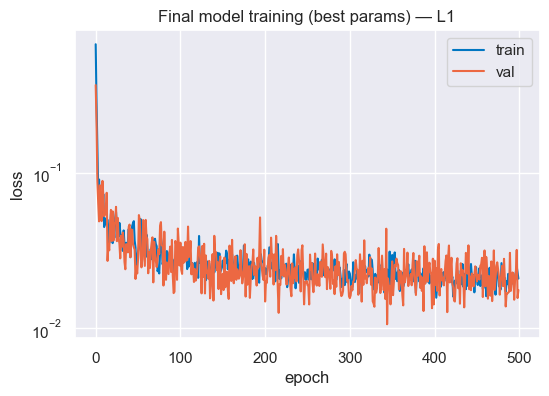

In [17]:
# Train a final model with best params and L1 loss
activation_map = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "SiLU": nn.SiLU(), "ELU": nn.ELU()}
loss_map = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}
optimizer_map = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

best_L1 = dict(study.best_params)
best_L1["loss"] = "L1"
print("Using params (L1):", best_L1)

model_L1 = FNN(
    input_size,
    output_size,
    hidden_features=best_L1["hidden_size"],
    activation_function=activation_map["ReLU"]
 ).to(device)

optimizer_L1 = optimizer_map[best_L1["optimizer"]](model_L1.parameters(), lr=best_L1["learning_rate"])
loss_function_L1 = loss_map["L1"]

FINAL_EPOCHS = 500
train_curve_L1, val_curve_L1 = [], []
best_val_L1 = float("inf")
best_epoch_L1 = None
best_state_L1 = None
min_delta = 1e-6

import copy

for epoch in range(1, FINAL_EPOCHS + 1):
    tr = train_epoch(model_L1, train_loader, optimizer_L1, loss_function_L1)
    vl = evaluation(model_L1, validation_loader, loss_function_L1)
    train_curve_L1.append(tr)
    val_curve_L1.append(vl)

    # Save-on-improvement: makes the best model robust to interruptions
    if vl < best_val_L1 - min_delta:
        best_val_L1 = vl
        best_epoch_L1 = epoch
        best_state_L1 = copy.deepcopy(model_L1.state_dict())

    if epoch % 20 == 0:
        print(f"final epoch {epoch} (L1): train={tr:.4f}, val={vl:.4f}")

# Restore best weights (so `model_L1` is the best model, not just the last epoch)
if best_state_L1 is not None:
    model_L1.load_state_dict(best_state_L1)
    print(f"Restored best L1 model from epoch {best_epoch_L1} (val={best_val_L1:.6f})")

# Optional: quick plot of curves
plt.figure(figsize=(6,4))
plt.plot(train_curve_L1, label="train")
plt.plot(val_curve_L1, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Final model training (best params) — L1")
plt.legend();

Using params (MSE): {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0050691542944099315, 'activation': 'ReLU', 'loss': 'MSE'}
final epoch 20 (MSE): train=0.0007, val=0.0009
final epoch 40 (MSE): train=0.0005, val=0.0012
final epoch 60 (MSE): train=0.0003, val=0.0003
final epoch 80 (MSE): train=0.0012, val=0.0007
final epoch 100 (MSE): train=0.0001, val=0.0002
final epoch 120 (MSE): train=0.0001, val=0.0001
final epoch 140 (MSE): train=0.0002, val=0.0007
final epoch 160 (MSE): train=0.0005, val=0.0003
final epoch 180 (MSE): train=0.0004, val=0.0010
final epoch 200 (MSE): train=0.0002, val=0.0001
final epoch 220 (MSE): train=0.0002, val=0.0001
final epoch 240 (MSE): train=0.0017, val=0.0019
final epoch 260 (MSE): train=0.0007, val=0.0004
final epoch 280 (MSE): train=0.0009, val=0.0006
final epoch 300 (MSE): train=0.0003, val=0.0003
final epoch 320 (MSE): train=0.0001, val=0.0001
final epoch 340 (MSE): train=0.0002, val=0.0001
final epoch 360 (MSE): train=0.0003, val=0.0002
f

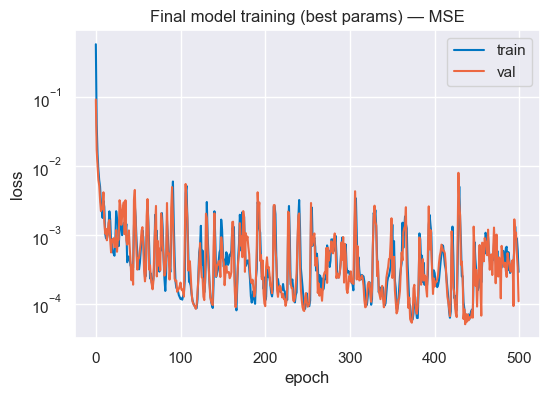

In [18]:
# Train a final model with best params and MSE loss
activation_map = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "SiLU": nn.SiLU(), "ELU": nn.ELU()}
loss_map = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}
optimizer_map = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

best_MSE = dict(study.best_params)
best_MSE["loss"] = "MSE"
print("Using params (MSE):", best_MSE)

model_MSE = FNN(
    input_size,
    output_size,
    hidden_features=best_MSE["hidden_size"],
    activation_function=activation_map["ReLU"]
 ).to(device)

optimizer_MSE = optimizer_map[best_MSE["optimizer"]](model_MSE.parameters(), lr=best_MSE["learning_rate"])
loss_function_MSE = loss_map["MSE"]

# Train and keep the best checkpoint (lowest validation loss)
import copy

FINAL_EPOCHS = 500
train_curve_MSE, val_curve_MSE = [], []
best_val_MSE = float("inf")
best_epoch_MSE = None
best_state_MSE = None
min_delta = 1e-6

for epoch in range(1, FINAL_EPOCHS + 1):
    tr = train_epoch(model_MSE, train_loader, optimizer_MSE, loss_function_MSE)
    vl = evaluation(model_MSE, validation_loader, loss_function_MSE)
    train_curve_MSE.append(tr)
    val_curve_MSE.append(vl)

    # Save-on-improvement: makes the best model robust to interruptions
    if vl < best_val_MSE - min_delta:
        best_val_MSE = vl
        best_epoch_MSE = epoch
        best_state_MSE = copy.deepcopy(model_MSE.state_dict())

    if epoch % 20 == 0:
        print(f"final epoch {epoch} (MSE): train={tr:.4f}, val={vl:.4f}")

# Restore best weights (so `model_MSE` is the best model, not just the last epoch)
if best_state_MSE is not None:
    model_MSE.load_state_dict(best_state_MSE)
    print(f"Restored best MSE model from epoch {best_epoch_MSE} (val={best_val_MSE:.6f})")

# Optional: quick plot of curves
plt.figure(figsize=(6,4))
plt.plot(train_curve_MSE, label="train")
plt.plot(val_curve_MSE, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Final model training (best params) — MSE")
plt.legend();

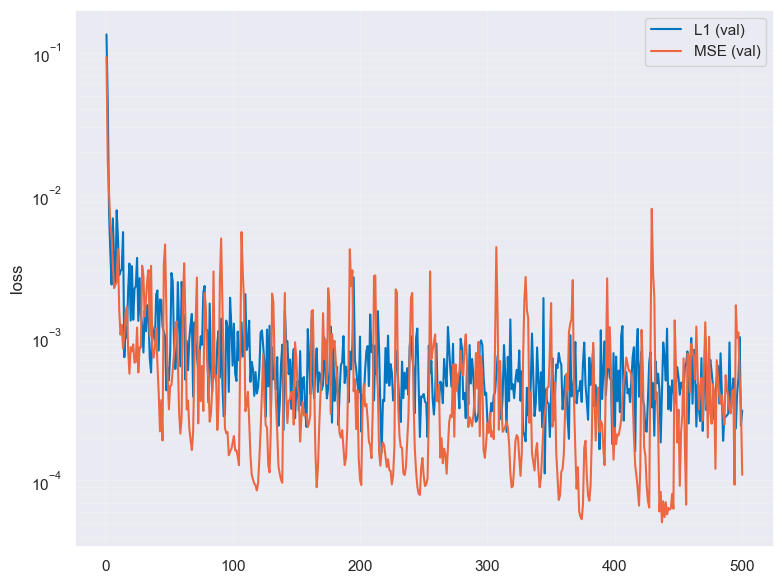

In [19]:
# Compare loss histories: L1 vs MSE (and their difference)
import numpy as np
import matplotlib.pyplot as plt

curve = "val"  # "val" or "train"

required = [
    "train_curve_L1", "val_curve_L1",
    "train_curve_MSE", "val_curve_MSE",
]

l1 = val_curve_L1 if curve == "val" else train_curve_L1
mse = val_curve_MSE if curve == "val" else train_curve_MSE

n = min(len(l1), len(mse))

l1 = np.asarray(l1[:n], dtype=float)
mse = np.asarray(mse[:n], dtype=float)
epochs = np.arange(1, n + 1)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

ax.plot(epochs, l1**2, label=f"L1 ({curve})")
ax.plot(epochs, mse, label=f"MSE ({curve})")
ax.set_yscale("log")
ax.set_ylabel("loss")
ax.grid(True, which="both", alpha=0.2)
ax.legend()

plt.tight_layout()
plt.show()

In [20]:
def compute_grid_relative_error(model, Nx=200, Nt=200, L=np.pi, t_max=None):
    """Grid relative L2 error (%) for the FNN on (x,t) -> (f,u).

    Uses the notebook's training normalizers:
    x_normalizer, t_normalizer, f_normalizer, u_normalizer.

    Returns a dict with errors in percent.
    """

    required = [
        "x_normalizer", "t_normalizer", "f_normalizer", "u_normalizer",
        "device",
    ]
    missing = [name for name in required if name not in globals()]
    if missing:
        raise NameError(
            "Missing variables: " + ", ".join(missing) +
            "\nRun the data/normalization cells first."
        )

    if t_max is None:
        t_max = float(globals().get("t_end", 1.0))

    # Build grid
    xv = np.linspace(0.0, float(L), int(Nx))
    tv = np.linspace(0.0, float(t_max), int(Nt))
    X, T = np.meshgrid(xv, tv, indexing="ij")  # shape (Nx, Nt)

    xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
    tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

    # Normalize inputs
    xg_n = x_normalizer.normalize(xg)
    tg_n = t_normalizer.normalize(tg)
    bg = torch.ones_like(xg_n)
    inputs = torch.cat([xg_n, tg_n, bg], dim=1)  # [N, 3]

    # Predict normalized outputs
    model.eval()
    with torch.no_grad():
        out_n = model(inputs)
        f_n, u_n = out_n.split(1, dim=-1)

    # Denormalize predictions to physical scale
    f_pred = f_normalizer.denormalize(f_n).cpu().numpy().reshape(Nx, Nt)
    u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)

    # True values from the exact functions (numpy)
    f_true = f(X, T)
    u_true = u(X, T)

    # Relative L2 errors in percent
    R_f = np.linalg.norm(f_pred - f_true) / (np.linalg.norm(f_true) + 1e-12) * 100.0
    R_u = np.linalg.norm(u_pred - u_true) / (np.linalg.norm(u_true) + 1e-12) * 100.0

    # Combined error on stacked outputs
    pred_stack = np.stack([f_pred, u_pred], axis=-1)
    true_stack = np.stack([f_true, u_true], axis=-1)
    R_all = np.linalg.norm(pred_stack - true_stack) / (np.linalg.norm(true_stack) + 1e-12) * 100.0

    print(f"Grid relative error (f):   {R_f:.6f}%")
    print(f"Grid relative error (u):   {R_u:.6f}%")

    return {"all_pct": float(R_all), "f_pct": float(R_f), "u_pct": float(R_u)}

# Example usage:
# compute_grid_relative_error(model_L1)
# compute_grid_relative_error(model_MSE)


In [23]:
# Run grid relative error for each model
# (uses x_normalizer/t_normalizer/f_normalizer/u_normalizer from this notebook)
print("Errors for L1 loss model:")
_ = compute_grid_relative_error(model_L1)
print()
print("Errors for L2 loss model:")
_ = compute_grid_relative_error(model_MSE)


Errors for L1 loss model:
Grid relative error (f):   1.397341%
Grid relative error (u):   1.389134%

Errors for L2 loss model:
Grid relative error (f):   0.785919%
Grid relative error (u):   0.787875%
